In [1]:
from unet import helper
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from unet import data

In [2]:
df = data.dataframe()

In [3]:
df['label'].value_counts()

car             123358
trafficlight     17253
pedestrian       15541
truck             7322
biker             1676
Name: label, dtype: int64

In [4]:
df['image_file'].value_counts().head

<bound method NDFrame.head of data/object-dataset/1478020419697386200.jpg              31
data/object-dataset/1478020420204575229.jpg              31
data/object-dataset/1478020420705248954.jpg              31
data/object-dataset/1478020419204218613.jpg              30
data/object-dataset/1478900835416176800.jpg              30
data/object-dataset/1478020422696366401.jpg              29
data/object-dataset/1478900834273691602.jpg              29
data/object-dataset/1478901306729719930.jpg              29
data/object-dataset/1478020421703195424.jpg              29
data/object-dataset/1478901406707009151.jpg              28
data/object-dataset/1478900834844439436.jpg              28
data/object-dataset/1478901306159002960.jpg              27
data/object-dataset/1478020464703286921.jpg              27
data/object-dataset/1478899618570376846.jpg              27
data/object-dataset/1478900833701930539.jpg              27
data/object-dataset/1478899206669204813.jpg              27
data/objec

In [5]:
image_factories = data.image_factories(df)

In [6]:
def mask_to_image(mask, color):
  image = np.zeros((mask.shape[0], mask.shape[1], 3), np.uint8)
  image[:] = color
  return cv2.bitwise_and(255, image, mask=mask)
  
def masks_to_image(masks, alpha=0.3):
  colors = get_spaced_colors(masks.shape[-1])
  image = np.zeros((masks.shape[0], masks.shape[1], 3), np.uint8)
  image[:,:,:] = 255
  
  for i in range(masks.shape[-1]):
    mask = masks[:,:,i]
    mask_image = mask_to_image(mask, colors[i])
    image = cv2.addWeighted(mask_image, alpha, image, 1 - alpha, 0, image)
    
  return image

def bounding_boxes_to_image(bounding_boxes, shape):
  colors = get_spaced_colors(5)
  image = np.zeros((shape[0], shape[1], 3), np.uint8)
  image[:,:,:] = 255
  labels = {
  'car': 0, 
  'pedestrian' : 1,
  'truck': 2,
  'trafficlight': 3,
  'biker': 4
  }
  for bb in bounding_boxes:
    image[bb.ymin:bb.ymax, bb.xmin:bb.xmax] = colors[labels[bb.label]]
    
  return image

def get_spaced_colors(n):
  max_value = 16581375 #255**3
  interval = int(max_value / n)
  colors = [hex(I)[2:].zfill(6) for I in range(255, max_value + 255, interval)]
  
  return [(int(i[:2], 16), int(i[2:4], 16), int(i[4:], 16)) for i in colors]

In [12]:
### Plotting generator output
def display_image_and_mask(image_obj, name):
    image = image_obj.image
    image_mask = np.array(image_obj.image_mask, np.uint8)
    flat_mask = np.array(np.amax(image_mask, axis=2), np.uint8)
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(bounding_boxes_to_image(image_obj.bounding_boxes, image.shape))
    ax2.set_title('Mask', fontsize=30)
    ax3.imshow(cv2.bitwise_and(image,image,mask=flat_mask))
    ax3.set_title('Image^Mask', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    plt.show()
#     plt.savefig(name + '.png')

In [8]:
def max_of_label(image_factories, label):
  return sorted(image_factories, key=lambda factory: len([bb for bb in factory.bounding_boxes if bb.label == label]))[-1]

max_cars_factory = max_of_label(image_factories, "car")
max_pedestrians_factory = max_of_label(image_factories, "pedestrian")
max_trucks_factory = max_of_label(image_factories, "truck")
max_trafficlights_factory = max_of_label(image_factories, "trafficlight")
max_bikers_factory = max_of_label(image_factories, "biker")

Image countains 15 of trafficlight


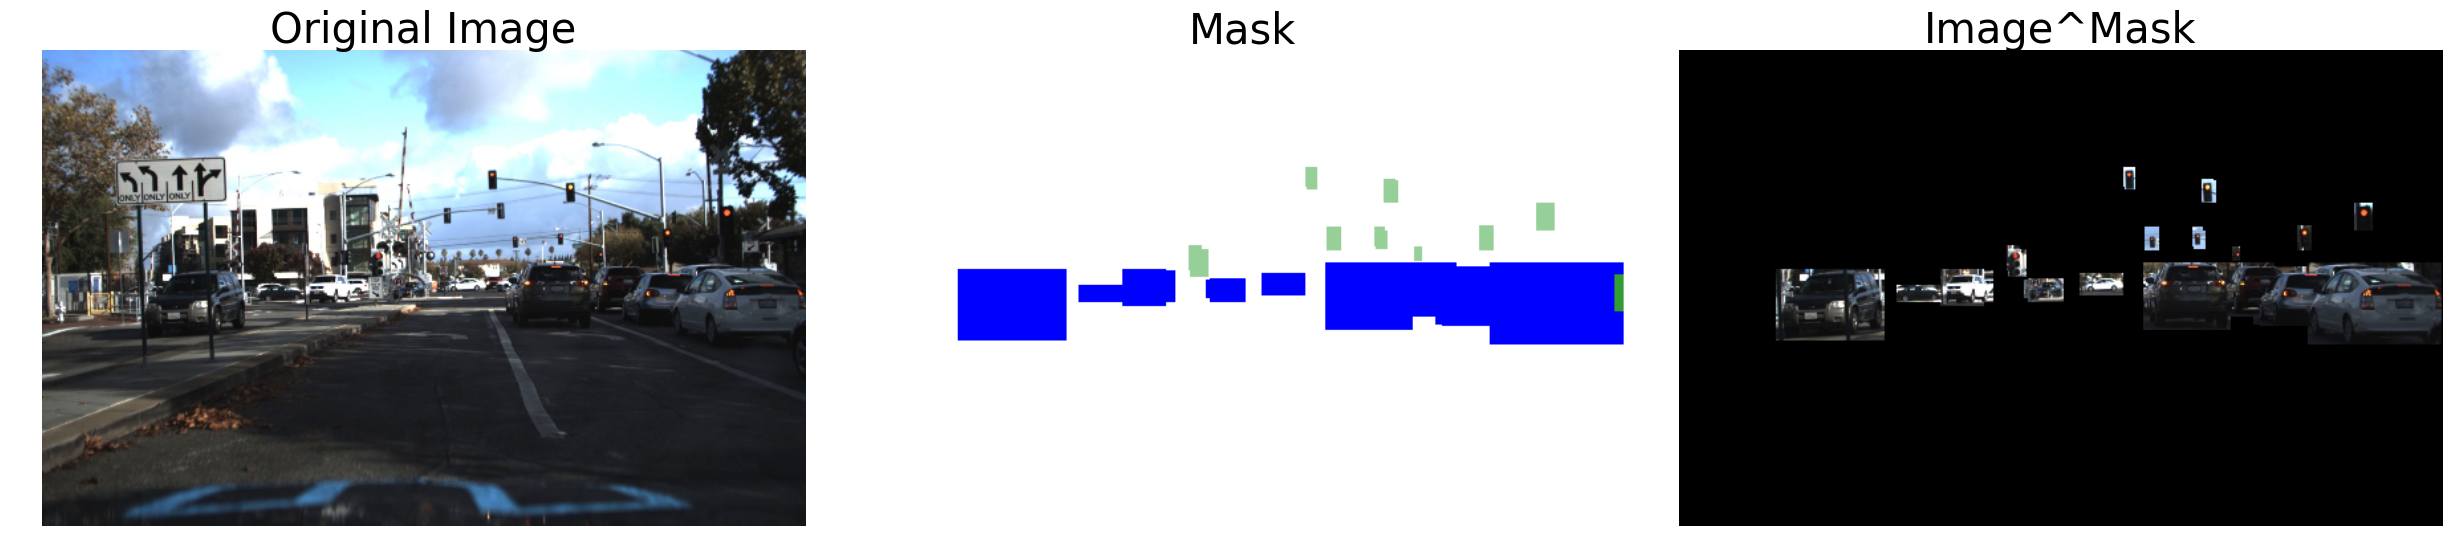

Image countains 21 of pedestrian


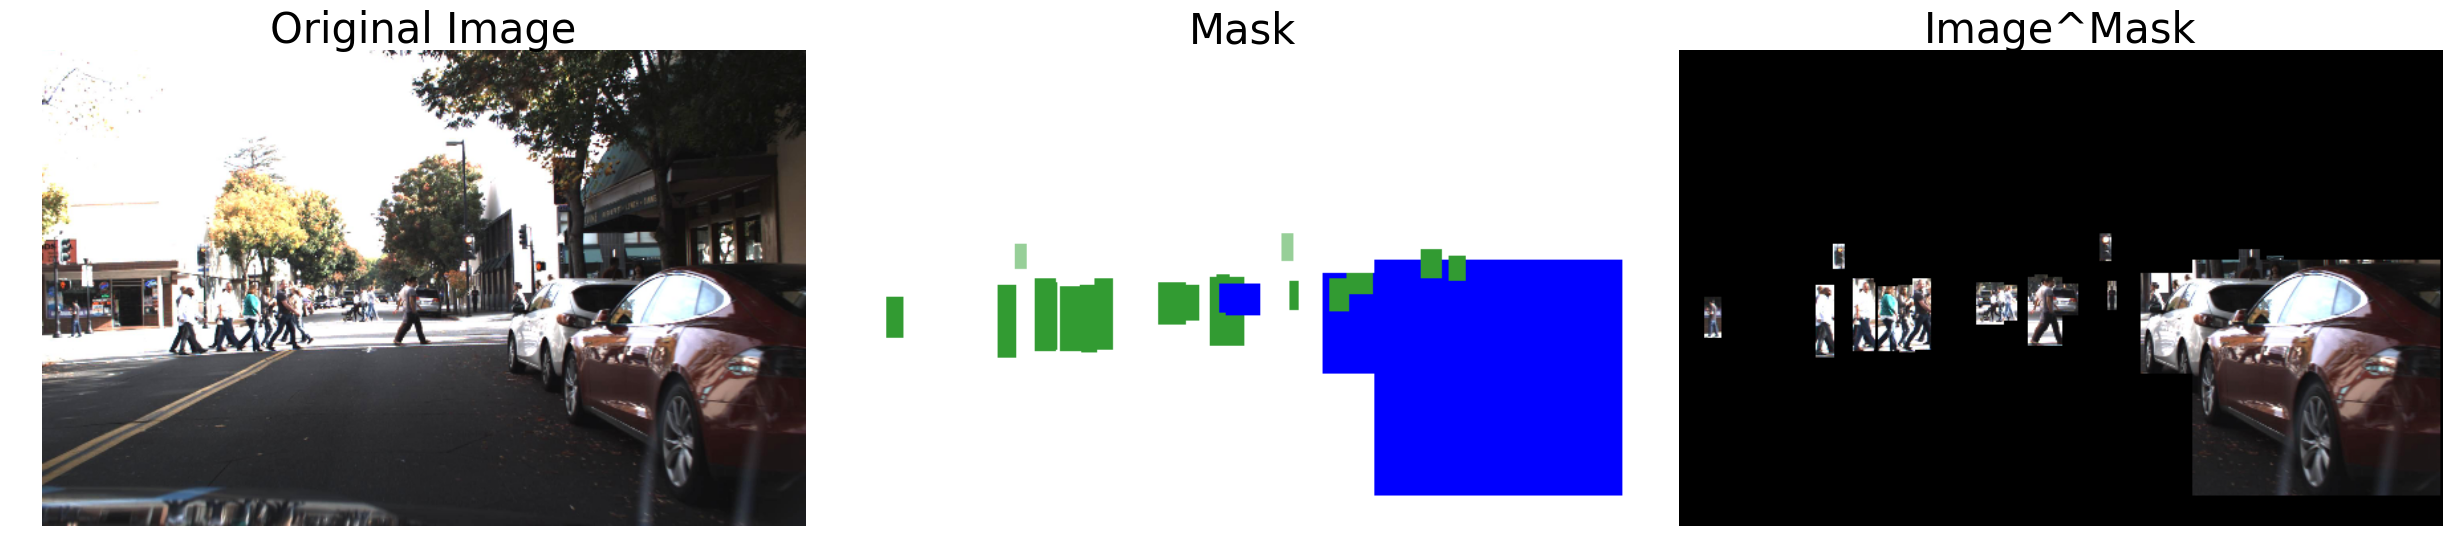

Image countains 6 of biker


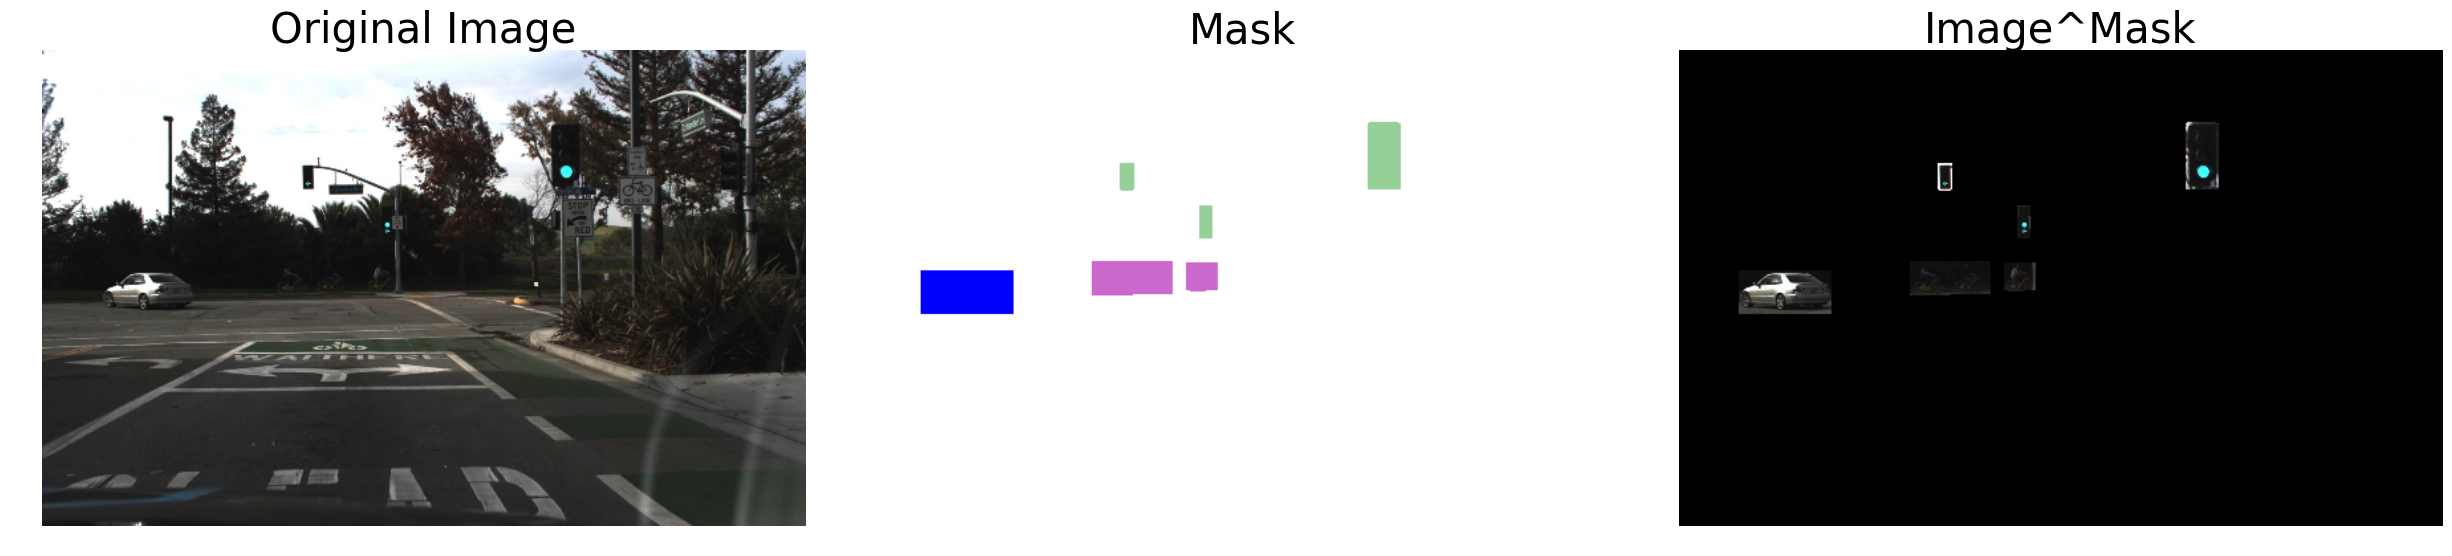

Image countains 6 of truck


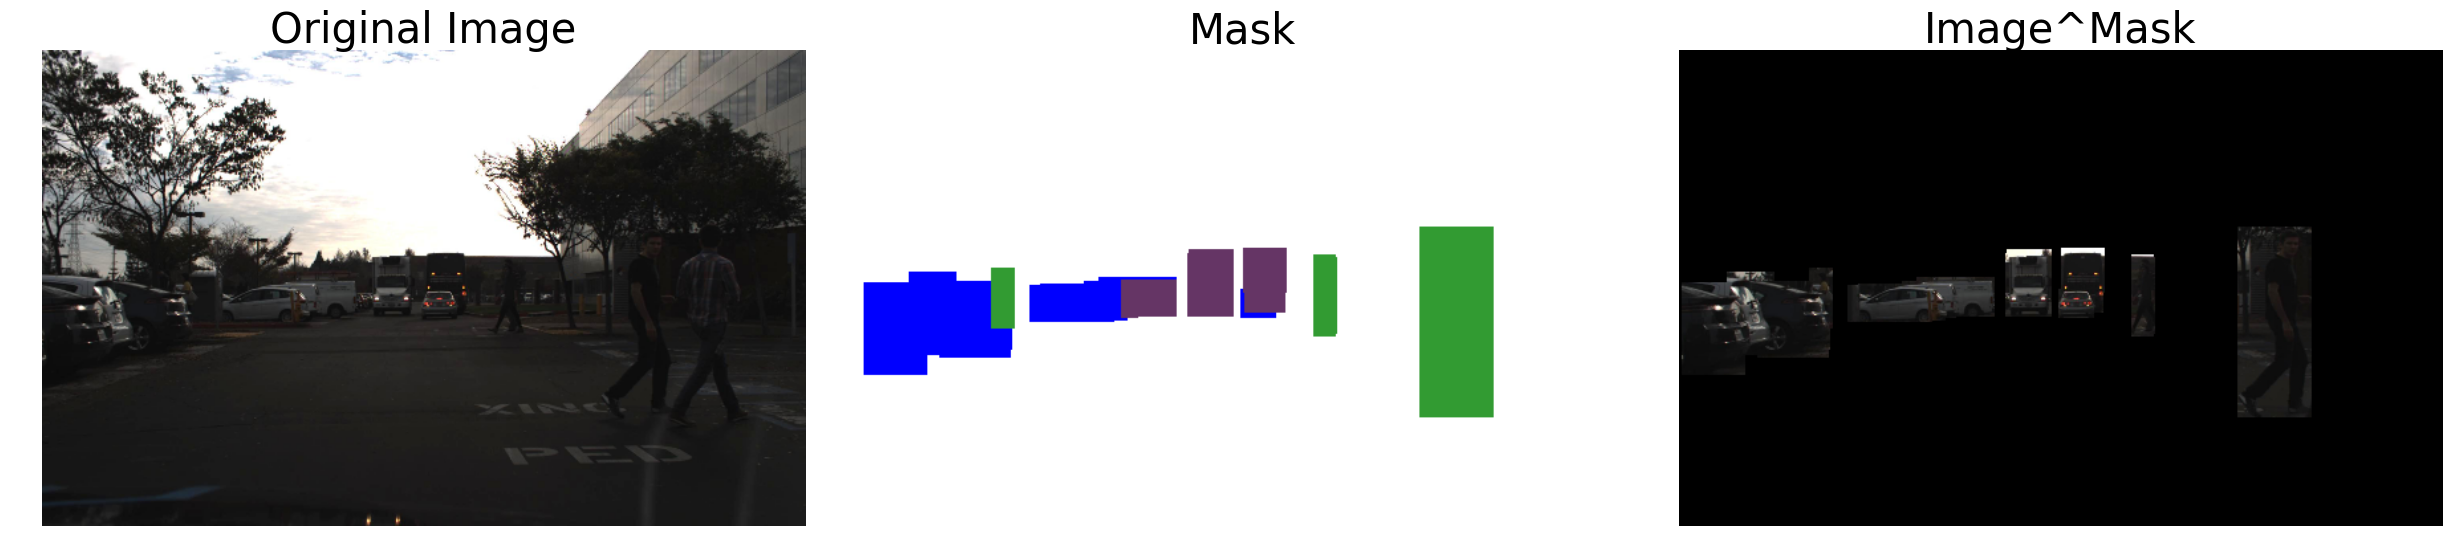

Image countains 24 of car


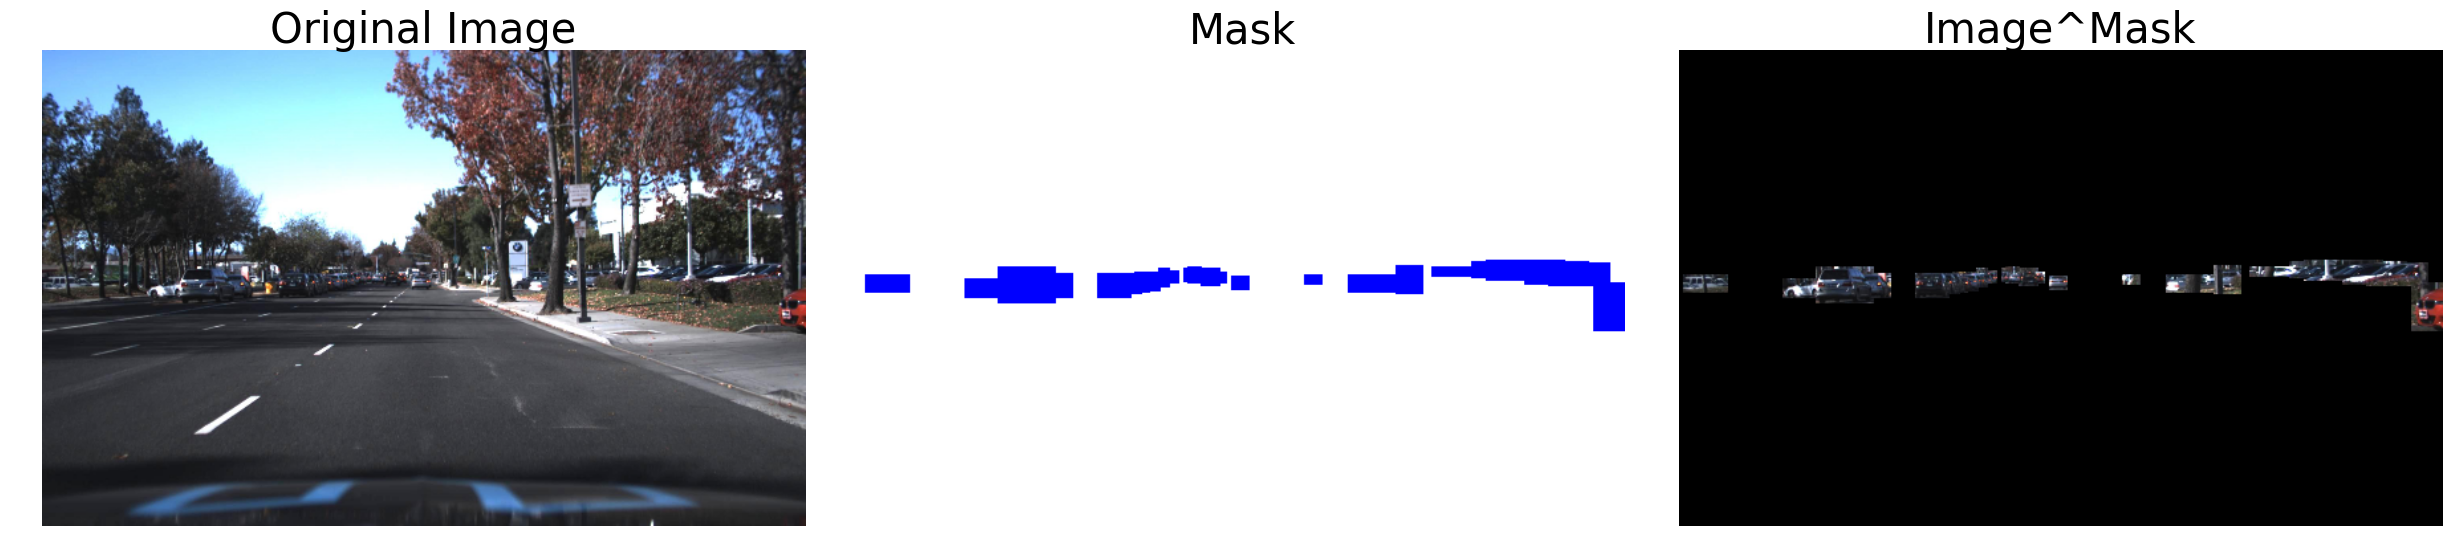

In [13]:
image_factories = sorted(image_factories, key=lambda factory: len(factory.bounding_boxes))
maxes = {
  'car':max_cars_factory, 
  'pedestrian':max_pedestrians_factory, 
  'truck':max_trucks_factory, 
  'trafficlight':max_trafficlights_factory, 
  'biker':max_bikers_factory}

for label, factory in maxes.items():
  count = len([bb for bb in factory.bounding_boxes if bb.label == label])
  print("Image countains", count, "of", label)
  image_obj = factory.image(augment=False)
  display_image_and_mask(image_obj, "max_" + label)